This notebook demonstrates filtering and reprojection of point cloud at a given viewpoint with camera metadata. Requires plotly package for points visualisation which can be installed through _pip install plotly_

In [21]:
import numpy as np
from PIL import Image, ImageDraw
import laspy
from matplotlib import pyplot as plt
from pyproj import Transformer
from scipy.spatial.transform import Rotation as R
from lidar.point_cloud_processings import remove_noise, get_rotation_matrix
import plotly.graph_objects as go

In [22]:
def project_lidar_perspective(point_cloud, position, orientation,resolution, fov, no_data_value=-9999):
    """
    Project LiDAR point cloud onto a 2D perspective image and calculate an elevation map.

    Parameters:
        point_cloud (numpy.ndarray): Nx3 array of LiDAR points (x, y, z).
        position (tuple): Viewpoint position as a 3-tuple (x, y, z).
        orientation (tuple): Viewpoint orientation as a 3-tuple (yaw, pitch, roll in radians).
        resolution (tuple): Image resolution (width, height) in pixels.
        fov (float): Horizontal field of view in radians.

    Returns:
        numpy.ndarray: 2D elevation map, averaged within each pixel grid.
    """
    # Unpack inputs
    px, py, pz = point_cloud.T  # Point cloud coordinates
    print('original points: ',point_cloud)
    vx, vy, vz = position  # Viewpoint position
    print('viewpoint: ',position)
    yaw, pitch, roll = orientation  # Viewpoint orientation
    img_width, img_height = resolution  # Image resolution

    # Step 1: Translate points to the viewpoint's position
    points = np.array([px - vx, py - vy, pz - vz]).T
    # Step 2: Apply rotation to align with the viewpoint's orientation
    # rotation_matrix = R.from_euler('zyx', [yaw, pitch, roll],degrees=False).as_matrix()
    # rotation_matrix = R.from_euler('XYZ', [roll, pitch, yaw],degrees=False).as_matrix()
    rotation_matrix=get_rotation_matrix(yaw, pitch,roll)
    print('rotation matrix: ',rotation_matrix)
    points = points @ rotation_matrix.T
    # print('Points transformed: ',points)
    print("Transformed X min/max:", np.min(points[:, 0]), np.max(points[:, 0]))
    print("Transformed Y min/max:", np.min(points[:, 1]), np.max(points[:, 1]))
    print("Transformed Z min/max:", np.min(points[:, 2]), np.max(points[:, 2]))

    print('total number of points: ',len(points))
    points = np.asarray(points)

    # Perspective projection parameters
    focal_length = 0.5 * img_width / np.tan(0.5 * fov)
    print('focal length in pixels:',focal_length)

    print("Min/max transformed Z:", np.min(points[:, 2]), np.max(points[:, 2]))
    valid = points[:, 2] > 0
    print("Number of points in front of the camera:", np.sum(valid))

    # Filter points in front of the camera (z > 0)
    x, y, z = points.T
    valid = z > 0
    x, y, z = x[valid], y[valid], z[valid]
    print('number of points in front of camera: ',np.sum(valid))

    # Project to image plane
    u = (focal_length * x / z + img_width / 2.0).astype(int)
    v = (focal_length * y / z + img_height / 2.0).astype(int)
    # Flip v-axis to match image coordinates (in many cases, v increases downward)
    v = img_height - v
    print('u: ',u)
    print('v: ',v)
    print('z: ',z)

    # Debugging: Check projected values
    print("Projected u min/max:", np.min(u), np.max(u))
    print("Projected v min/max:", np.min(v), np.max(v))

    # Clip points to be within image bounds
    valid_pixels = (u >= 0) & (u < img_width) & (v >= 0) & (v < img_height)
    print('number of points within view: ',np.sum(valid_pixels))
    u, v, z = u[valid_pixels], v[valid_pixels], z[valid_pixels]

    # Create an elevation map and track counts for averaging
    elevation_map = np.zeros((img_height, img_width), dtype=np.float32)
    counts = np.zeros((img_height, img_width), dtype=np.int32)

    for px, py, z_val in zip(u, v, z):
        elevation_map[py, px] += z_val  # Accumulate elevation values
        counts[py, px] += 1            # Count the number of points per pixel

    # Avoid division by zero and calculate the average elevation
    non_zero = counts > 0
    elevation_map[non_zero] /= counts[non_zero]

    # Replace zero or invalid elevation values with a no-data value (e.g., -1 for invalid elevation)
    elevation_map[~non_zero] = no_data_value

    return elevation_map


In [23]:
def project_lidar_equirectangular(point_cloud, position, orientation, hfov, vfov, resolution,no_data_value=-9999):
    """
    Calculate an elevation image from a point cloud projected within the field of view.

    Parameters:
        point_cloud (numpy.ndarray): Array of shape (N, 3) with 3D points (x, y, z).
        position (tuple): Viewpoint position as a 3-tuple (x, y, z).
        orientation (tuple): Viewpoint orientation as a 3-tuple (yaw, pitch, roll in radians).
        hfov (float): Horizontal field of view in radians.
        vfov (float): Vertical field of view in radians.
        resolution (tuple): Image resolution (width, height).

    Returns:
        numpy.ndarray: 2D array representing the elevation image.
    """
    # Unpack inputs
    px, py, pz = point_cloud.T  # Point cloud coordinates
    vx, vy, vz = position  # Viewpoint position
    yaw, pitch, roll = orientation  # Viewpoint orientation
    img_width, img_height = resolution  # Image resolution

    # Step 1: Translate points to the viewpoint's position
    points = np.array([px - vx, py - vy, pz - vz]).T

    # Step 2: Apply rotation to align with the viewpoint's orientation
    # rotation_matrix = R.from_euler('zyx', [yaw, pitch, roll]).as_matrix()
    rotation_matrix=get_rotation_matrix(yaw, pitch,roll)
    points = points @ rotation_matrix.T

    # Step 3: Convert to spherical coordinates
    r = np.linalg.norm(points, axis=1)  # Radial distance
    # theta = np.arctan2(points[:, 2], points[:, 0])  # Azimuth angle
    theta = np.arctan2(points[:, 0], r)  # Azimuth angle
    # phi = np.arcsin(points[:, 1] / r)  # Elevation angle
    phi = np.arctan2((-1.0)*points[:, 1], r)  # Elevation angle

    print('r: ',r)
    print('theta: ',theta)
    print('phi: ',phi)

    # Step 4: Filter points within the field of view
    mask = (
        (theta >= -hfov / 2) & (theta <= hfov / 2) &
        (phi >= -vfov / 2) & (phi <= vfov / 2)
    )
    print('number of points within view: ',np.sum(mask))
    points = points[mask]
    theta = theta[mask]
    phi = phi[mask]
    r = r[mask]

    # Step 5: Map to image plane
    u = ((theta + hfov / 2) / hfov * img_width).astype(int)
    v = ((phi + vfov / 2) / vfov * img_height).astype(int)

    print('min/max u: ',np.min(u),np.max(u))
    print('min/max v: ',np.min(v),np.max(v))
    u = np.clip(u, 0, img_width - 1)
    v = np.clip(v, 0, img_height - 1)

    # Step 6: Create the elevation image
    elevation_map = np.zeros((img_height, img_width), dtype=np.float32)
    counts = np.zeros((img_height, img_width), dtype=np.int32)
    for px, py, z_val in zip(u, v, r):
        elevation_map[py, px] += z_val  # Accumulate elevation values
        counts[py, px] += 1            # Count the number of points per pixel

    # Avoid division by zero and calculate the average elevation
    non_zero = counts > 0
    elevation_map[non_zero] /= counts[non_zero]
    # Replace zero or invalid elevation values with a no-data value (e.g., -1 for invalid elevation)
    elevation_map[~non_zero] = no_data_value

    return elevation_map


### Read LiDAR points from a .las file

In [24]:
las_file_path = r"C:\Users\lliu\Desktop\FrontierSI\projects\GA_floor_height\QA4lidar\2_clipped_buffered.las"
with laspy.open(las_file_path) as las:
    lidar_data = las.read()
    lidar_points = np.vstack((lidar_data.x, lidar_data.y, lidar_data.z)).T  # Extract x, y, z coordinates


### Filter point cloud

In [25]:
# Remove noise points using DBSCAN
eps = 3  # Maximum distance between points to be considered neighbors (meters)
min_samples = 2  # Minimum number of points to form a cluster
lidar_points = remove_noise(lidar_points, eps, min_samples)
lidar_points

array([[7.25662140e+05, 7.66213392e+06, 1.02200000e+01],
       [7.25662650e+05, 7.66213256e+06, 8.65000000e+00],
       [7.25662560e+05, 7.66213255e+06, 8.77000000e+00],
       ...,
       [7.25659340e+05, 7.66214385e+06, 1.03200000e+01],
       [7.25659150e+05, 7.66214469e+06, 1.03500000e+01],
       [7.25659010e+05, 7.66214482e+06, 1.02900000e+01]])

### Set camera metadata


In [26]:
# Camera in EPSG:4326 (longitude, latitude, height)
# camera_position = (149.1728570, -21.1282603, 10)  
camera_position = (149.1726996, -21.1281156, 10)  
# yaw = np.radians(0)         # Camera yaw angle
yaw = np.radians(90)         # Camera yaw angle
pitch = np.radians(0)        # Camera pitch angle
roll = np.radians(0)         # Camera roll angle
orientation=(yaw, pitch, roll)
# Image dimensions
image_width = 512
image_height = 512
resolution=(image_width,image_height)
# Field of views in degrees
fov_v=np.radians(90)
fov_h = np.radians(90)
# fill value for background pixels
nodata_value=-9999

### Reproject viewpoint to CRS of point cloud

In [27]:
transformer = Transformer.from_crs("EPSG:4326", "EPSG:28355", always_xy=True)
camera_easting, camera_northing = transformer.transform(camera_position[0], camera_position[1])
camera_position=(camera_easting, camera_northing,camera_position[2])
camera_position

(725653.1460448012, 7662130.643201064, 10)

### Visualise point cloud and viewpoint

In [28]:
# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=lidar_points[:, 0],
    y=lidar_points[:, 1],
    z=lidar_points[:, 2],
    mode='markers',
    marker=dict(size=1, color='blue')),
    go.Scatter3d(
    x=[camera_position[0]],
    y=[camera_position[1]],
    z=[camera_position[2]],
    mode='markers',
    marker=dict(size=5, color='red'))])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Show the plot
fig.show()

### project point cloud

In [29]:
# Project points
# elevation_image = project_lidar_perspective(lidar_points, camera_position, orientation, resolution, fov_h,no_data_value=nodata_value)
elevation_image = project_lidar_equirectangular(lidar_points, camera_position, orientation, fov_h, fov_v,resolution,no_data_value=nodata_value)

r:  [ 9.57481286  9.78886013  9.68356002 ... 14.59064835 15.28013542
 15.34443543]
theta:  [-0.32973707 -0.19336764 -0.19442356 ... -0.7356559  -0.74336819
 -0.74586634]
phi:  [ 0.02297291 -0.13704737 -0.12634283 ...  0.02192834  0.02290155
  0.01889711]
number of points within view:  9949
min/max u:  11 470
min/max v:  208 311


array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

### Visualise projected image

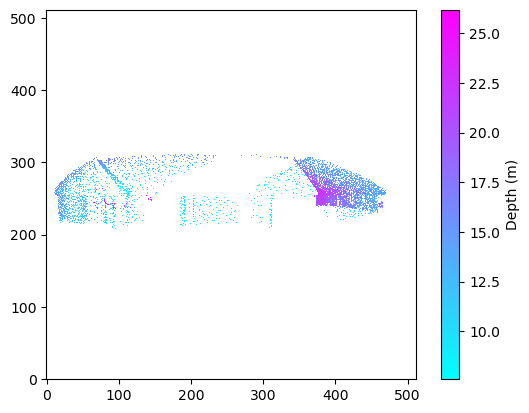

In [30]:
elevation_image_copy=elevation_image.copy()
elevation_image_copy[elevation_image_copy==nodata_value] = np.nan
plt.imshow(elevation_image_copy,cmap='cool',interpolation='none',origin='lower')
# plt.imshow(elevation_image_copy,cmap='cool',interpolation='none')
plt.colorbar(label='Depth (m)')